In [ ]:
import numpy as np
from scipy.special import gammaln
from scipy.stats import dirichlet
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import norm
from sklearn.metrics import adjusted_rand_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = "/content/drive/MyDrive/UET/Gro-M3s/"
nltcs_path = dir_path + "2to16disabilityNLTCS.txt"
ipip_path = dir_path + "data.csv"

In [ ]:
iterations = 5000
burn_in = 2500
thin = 10

In [ ]:
def update_Lambda(Y, z, s, G, K, d):
    n, p = Y.shape
    lambda_new = np.zeros((p, d, K))
    for j in range(p):
        g = s[j]
        for k in range(K):
            counts = np.ones(d) * 1.0
            for i in range(n):
                if z[i, g] == k:
                    counts[Y[i, j] - 1] += 1
            lambda_new[j, :, k] = np.random.dirichlet(counts)
    return lambda_new

def update_z(Y, lbd, pi, s, G, K):
    """
    Update latent z_{i,g} for each sample i and group g using log-probs to avoid underflow.
    """
    n, p = Y.shape
    z_new = np.zeros((n, G), dtype=int)
    for i in range(n):
        for g in range(G):
            log_probs = np.log(pi[i] + 1e-18).copy()
            idx = np.where(s == g)[0]
            for j in idx:
                log_probs += np.log(lbd[j, Y[i, j] - 1, :] + 1e-18)
            log_probs -= np.max(log_probs)
            probs = np.exp(log_probs)
            probs /= probs.sum()
            z_new[i, g] = np.random.choice(K, p=probs)
    return z_new

def update_pi(z, alpha):
    """
    Gibbs update for pi_i ~ Dirichlet(alpha + counts)
    """
    n, G = z.shape
    K = len(alpha)
    pi_new = np.zeros((n, K))
    for i in range(n):
        counts = np.bincount(z[i], minlength=K) + alpha
        pi_new[i] = np.random.dirichlet(counts)
    return pi_new

def update_xi(s, G):
    """
    Gibbs update for xi ~ Dirichlet(1 + #variables assigned to each group)
    """
    counts = np.bincount(s, minlength=G) + 1
    return np.random.dirichlet(counts)

def update_s_gibbs(Y, z, lbd, xi, G, K):
    n, p = Y.shape
    d = lbd.shape[1]
    s_new = np.zeros(p, dtype=int)
    for j in range(p):
        log_probs = np.log(xi + 1e-18).copy()
        for g in range(G):
            idx = np.where(z[:, g] >= 0)[0]
            ks = z[idx, g]
            ys = Y[idx, j] - 1
            log_probs[g] += np.sum(np.log(lbd[j, ys, ks] + 1e-18))
        log_probs -= np.max(log_probs)
        probs = np.exp(log_probs)
        probs /= probs.sum()
        s_new[j] = np.random.choice(G, p=probs)
    return s_new

def log_gamma_prior(alpha, a=1.0, b=1.0):
    return (a - 1) * np.sum(np.log(alpha)) - b * np.sum(alpha)

def update_alpha(alpha, pi, a_alpha=2.0, b_alpha=1.0, proposal_sd=0.002):
    log_alpha = np.log(alpha)
    log_alpha_prop = log_alpha + np.random.normal(scale=proposal_sd, size=alpha.shape)
    alpha_prop = np.exp(log_alpha_prop)

    log_prior_old = (a_alpha - 1) * np.sum(np.log(alpha)) - b_alpha * np.sum(alpha)
    log_prior_new = (a_alpha - 1) * np.sum(np.log(alpha_prop)) - b_alpha * np.sum(alpha_prop)

    log_lik_old = np.sum([dirichlet.logpdf(pi_i, alpha) for pi_i in pi])
    log_lik_new = np.sum([dirichlet.logpdf(pi_i, alpha_prop) for pi_i in pi])

    accept_prob = np.exp(log_lik_new + log_prior_new - log_lik_old - log_prior_old)
    if np.random.rand() < accept_prob:
        return alpha_prop
    else:
        return alpha

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# IPIP Data

In [ ]:
ipip_data = pd.read_csv(ipip_path)  # n = 1005 x p = 42
as_cols = [f"AS{i}" for i in range(1, 11)]
sc_cols = [f"SC{i}" for i in range(1, 11)]
ad_cols = [f"AD{i}" for i in range(1, 11)]
do_cols = [f"DO{i}" for i in range(1, 11)]
question_cols = as_cols + sc_cols + ad_cols + do_cols
ipip_data = ipip_data[(ipip_data[question_cols] != 0).all(axis=1)]
feature_names = ipip_data.columns.tolist()
reverse_items = [f"AS{i}" for i in range(7, 11)] + \
                [f"SC{i}" for i in range(6, 11)] + \
                [f"AD{i}" for i in range(5, 11)]
for col in reverse_items:
    ipip_data[col] = 6 - ipip_data[col]  # Likert scale 1–5 for reverse items

ipip_data = ipip_data[question_cols].reset_index(drop=True)
ipip_data = ipip_data.to_numpy()  # n x p (n=901, p=40)

print(ipip_data.shape)

(901, 40)


In [ ]:
n, p = ipip_data.shape
G = 5
K = 4
d = 5

s = np.random.choice(np.arange(G), size=p)
lbd = np.ones((p, d, K)) * 1.0 / d
alpha = np.ones(K) * 0.5
pi = np.random.dirichlet(alpha, size=n)
z = np.random.randint(0, K, size=(n, G))
xi   = np.ones(G) / G

In [ ]:
samples = []
for it in range(iterations):
    if (it+1) % 100 == 0:
        print(f"Iteration {it + 1}")
    lbd = update_Lambda(ipip_data, z, s, G, K, d)
    z   = update_z(ipip_data, lbd, pi, s, G, K)
    pi  = update_pi(z, alpha)
    alpha = update_alpha(alpha, pi)
    xi  = update_xi(s, G)
    s   = update_s_gibbs(ipip_data, z, lbd, xi, G, K)

    if it >= burn_in and (it - burn_in) % thin == 0:
        samples.append((lbd.copy(), z.copy(), pi.copy(), alpha.copy(), s.copy(), xi.copy()))

print(f"Number of samples after burn-in: {len(samples)}")

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 2500
Iteration 2600
Iteration 2700
Iteration 2800
Iteration 2900
Iteration 3000
Iteration 3100
Iteration 3200
Iteration 3300
Iteration 3400
Iteration 3500
Iteration 3600
Iteration 3700
Iteration 3800
Iteration 3900
Iteration 4000
Iteration 4100
Iteration 4200
Iteration 4300
Iteration 4400
Iteration 4500
Iteration 4600
Iteration 4700
Iteration 4800
Iteration 4900
Iteration 5000
Number of samples after burn-in: 250


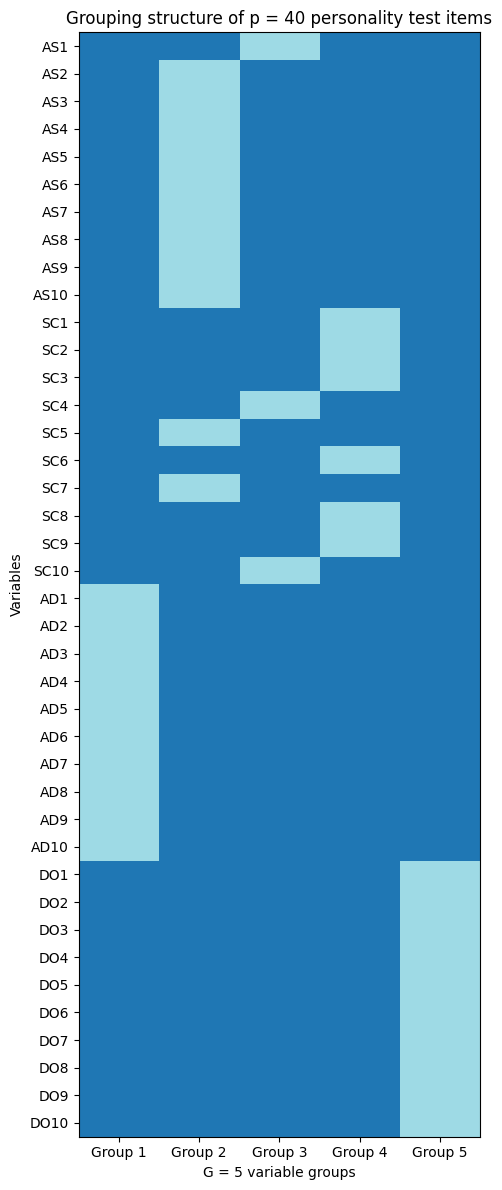

In [ ]:
s_samples = np.array([s_ for (_, _, _, _, s_, _) in samples])
s_mode = stats.mode(s_samples, axis=0, keepdims=False).mode

L_mode = np.zeros((p, G))
for j in range(p):
    L_mode[j, s_mode[j]] = 1

var_labels = (
    [f"AS{i}" for i in range(1, 11)] +
    [f"SC{i}" for i in range(1, 11)] +
    [f"AD{i}" for i in range(1, 11)] +
    [f"DO{i}" for i in range(1, 11)]
)

plt.figure(figsize=(5, 12))
im = plt.imshow(L_mode, aspect='auto', cmap='tab20') # , interpolation='nearest')

plt.yticks(ticks=np.arange(p), labels=var_labels)
plt.xticks(ticks=np.arange(G), labels=[f"Group {g+1}" for g in range(G)], rotation=0)
plt.ylabel("Variables")
plt.xlabel("G = 5 variable groups")
plt.title("Grouping structure of p = 40 personality test items")
plt.tight_layout()
plt.show()

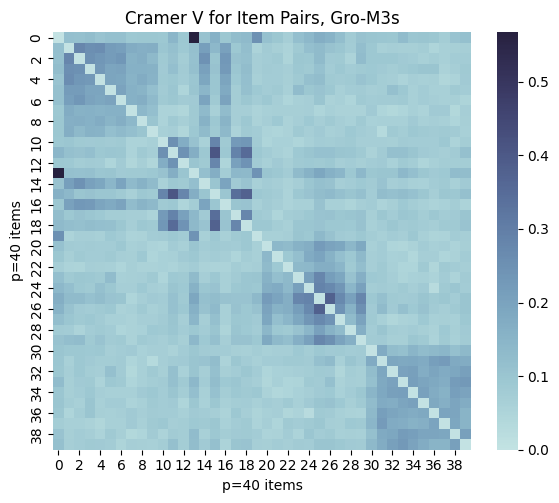

In [ ]:
lambda_mode, _, _, _, s_mode, _ = samples[-1]
z_mode = np.argmax(dirichlet.rvs(alpha, size=n), axis=1)

# p(y_j = a | z)
p = ipip_data.shape[1]
d = 5
probs = np.zeros((p, d, K))
for j in range(p):
    g = s_mode[j]
    for k in range(K):
        probs[j, :, k] = lambda_mode[j, :, k]

np.random.seed(42)
n_sim = 1000
sim_data = np.zeros((n_sim, p), dtype=int)
pi_sim = dirichlet.rvs(alpha, size=n_sim)

for i in range(n_sim):
    z_i = np.array([np.random.choice(K, p=pi_sim[i]) for _ in range(G)])
    for j in range(p):
        g = s_mode[j]
        k = z_i[g]
        sim_data[i, j] = np.random.choice(np.arange(1, d+1), p=probs[j, :, k])

cramers_grom3 = np.zeros((p, p))
for i in range(p):
    for j in range(p):
        if i != j:
            cramers_grom3[i, j] = cramers_v(sim_data[:, i], sim_data[:, j])

plt.figure(figsize=(6, 5))
sns.heatmap(cramers_grom3, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), square=True)
plt.title("Cramer V for Item Pairs, Gro-M3s")
plt.xlabel("p=40 items")
plt.ylabel("p=40 items")
plt.tight_layout()
plt.show()